In [5]:
import numpy as np
from neuralStellar import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T

In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_30/small_grid_model.h5')
m1.getWeights()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
_________________________________________________________

# Create the pseudo-cluster data from NN

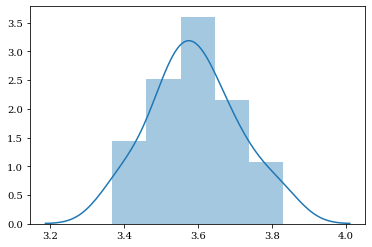

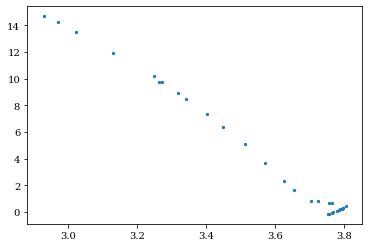

In [3]:
iso_age = 3.6
spread = 0.1
N = 30
Tage = np.random.randn(N)*spread+iso_age
sns.distplot(Tage)
plt.show()
Tmass = np.random.rand(N)*(2-0.8)+0.8
Tfeh = np.zeros(N)
TMLT = np.ones(N)*1.9

Tinputs = np.log10(np.vstack((Tmass, Tage, 10**Tfeh, 10**TMLT)))
Toutputs = m1.model.predict(Tinputs.T).T
[TL, TTeff, Tdelnu] = 10**Toutputs
plt.scatter(np.log10(TTeff), np.log10(TL), s=5)
plt.show()

# HBM!!

In [23]:
'''
#age mean - normal
Age_lb_mu = 3.6-0.1
Age_lb_sigma = 0.05
#age sigma - log normal
Age_range_mu = np.log(0.1)
Age_range_sigma = 0.5

model = pm.Model()
with model:
    Age_lb = pm.Normal('lb_age',3.6, 0.2)
    Age_range = pm.Lognormal('range_age', T.log(0.1), 0.5)
    
    Age = pm.Deterministic('age', pm.Normal('b',0,1,shape=N)*Age_range+Age_lb)
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(2-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict([T.log10(M), T.log10(Age), feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0,:],0.1, observed=TL)
    #obs_Teff = pm.Normal('obs_Teff',10**obs[1,:],70, observed=TTeff)
    #obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)
'''
model = pm.Model()
with model:
    Age_mu = pm.Normal('mean_age', 3.6, 0.2)
    Age = pm.Normal('age', Age_mu, 0.1, shape=N)
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(2-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict([T.log10(M), T.log10(Age), feh, MLT]))
    
    #obs_L = pm.Normal('obs_L',10**obs[0,:],0.1, observed=TL)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1,:],70, observed=TTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)

[Elemwise{log10,no_inplace}.0, Elemwise{log10,no_inplace}.0, feh, MLT]


In [25]:
start = {'mean_age':3.6}
with model:
    trace = pm.sample(tune=5000, init='adapt_diag', start=start, target_accept=0.99, cores=1, chains=1)
    #mean_field = pm.fit(n=50000, method='advi')
    #advi = pm.ADVI()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, age, mean_age]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013A3603E898>,
      dtype=object)

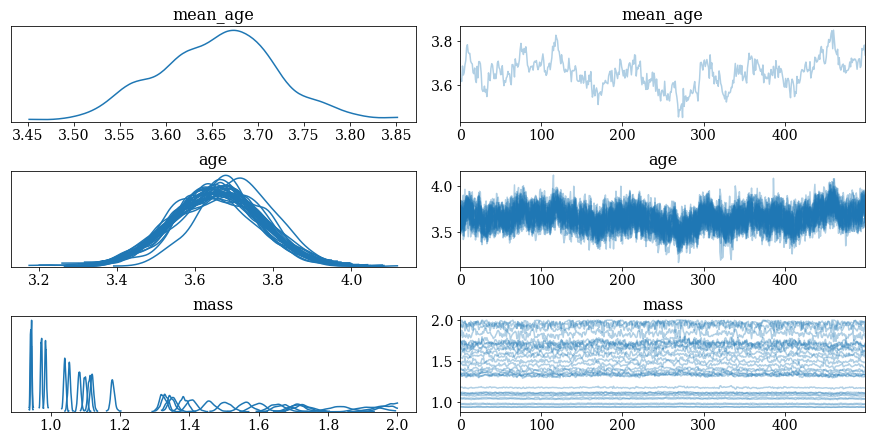

In [26]:
pm.plots.traceplot(trace,var_names=['mean_age','age','mass'],compact=True)

In [ ]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)
approx = advi.fit(20000, callbacks=[tracker])

In [ ]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B12FD06320>,
      dtype=object)

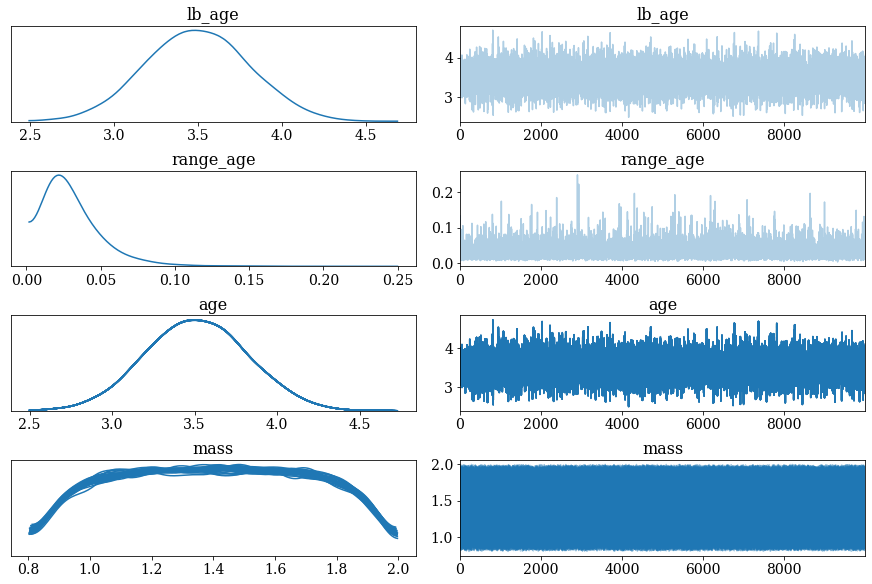

In [54]:
trace = mean_field.sample(10000)
pm.plots.traceplot(trace,var_names=['lb_age','range_age','age','mass'],compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B1297C5940>,
      dtype=object)

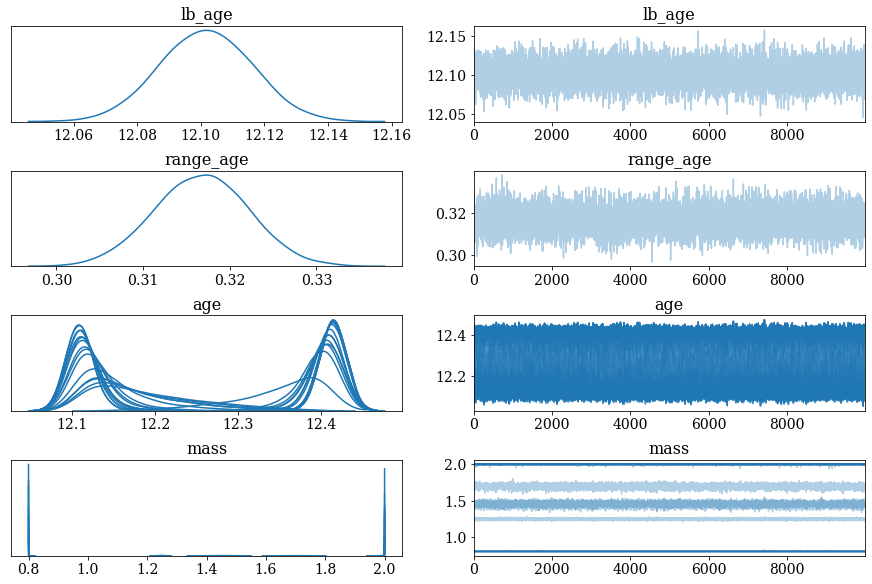

In [32]:
trace = mean_field.sample(10000)
pm.plots.traceplot(trace,var_names=['lb_age','range_age','age','mass'],compact=True)

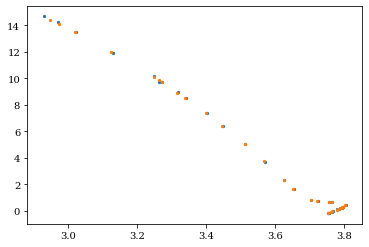

In [27]:
mean_ages=np.mean(trace['age'],axis=0)
mean_masses = np.mean(trace['mass'],axis=0)
Finputs = np.log10(np.vstack((mean_masses, mean_ages, 10**Tfeh, 10**TMLT)))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
plt.scatter(np.log10(TTeff), np.log10(TL), s=5)
plt.scatter(np.log10(FTeff), np.log10(FL), s=5)
plt.show()

In [33]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lb_age,12.102,0.014,12.075,12.129,0.000,0.000,10268.0,10268.0,10263.0,9719.0,NaN
range_age,0.317,0.005,0.307,0.327,0.000,0.000,10471.0,10471.0,10469.0,9723.0,NaN
b[0],0.987,0.015,0.962,1.000,0.000,0.000,9840.0,9840.0,10234.0,9738.0,NaN
b[1],0.968,0.035,0.909,0.999,0.000,0.000,9712.0,9712.0,9748.0,9769.0,NaN
b[2],0.992,0.009,0.978,1.000,0.000,0.000,10168.0,10168.0,10109.0,9760.0,NaN
b[3],0.972,0.030,0.920,0.999,0.000,0.000,9386.0,9379.0,9202.0,9847.0,NaN
b[4],0.953,0.052,0.867,0.999,0.001,0.000,9769.0,9769.0,9910.0,9726.0,NaN
b[5],0.922,0.075,0.786,0.998,0.001,0.001,9536.0,9463.0,9389.0,9757.0,NaN
b[6],0.068,0.069,0.001,0.189,0.001,0.000,10162.0,10162.0,10185.0,10212.0,NaN
b[7],0.035,0.037,0.001,0.096,0.000,0.000,8926.0,8926.0,8830.0,9641.0,NaN


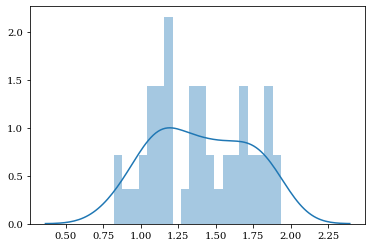

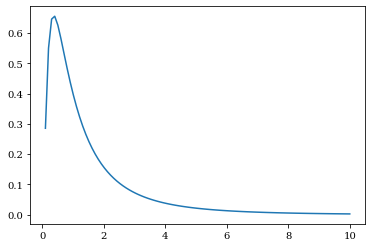

In [25]:
x=np.linspace(0,10,100)
mu=np.log(1)
sigma=1
y=(1/x)/(sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
plt.plot(x,y)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

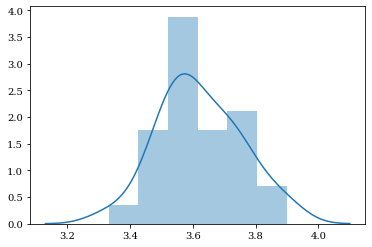

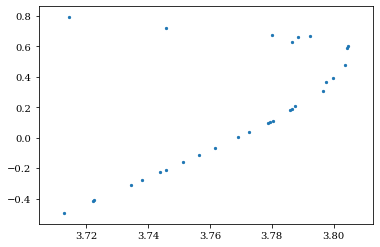

In [31]:
m2=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m2.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
m2.getWeights()
TTage = np.random.randn(N)*spread+3.6
sns.distplot(TTage)
plt.show()
TTmass = np.random.rand(N)*(1.4-0.8)+0.8
TTfeh = np.zeros(N)
TTMLT = np.ones(N)*1.9

TTinputs = np.log10(np.vstack((TTmass, TTage, 10**TTfeh, 10**TTMLT)))
TToutputs = m1.model.predict(TTinputs.T).T
[TTL, TTTeff, TTdelnu] = 10**TToutputs
plt.scatter(np.log10(TTTeff), np.log10(TTL), s=5)
plt.show()